# LHCb Magnetic Field Map Exploration

This notebook explores the `twodip.rtf` field map to understand:
1. The data format and grid structure
2. The spatial extent and resolution
3. The field strength and distribution (especially By)
4. How to use this in our PINN training

**File:** `/data/bfys/gscriven/TE_stack/Rec/Tr/TrackExtrapolators/field_maps/twodip.rtf`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

# For interactive plots
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. Load the Field Map Data

In [2]:
# Load the field map
field_path = '/data/bfys/gscriven/TE_stack/Rec/Tr/TrackExtrapolators/field_maps/twodip.rtf'

print("Loading field map (this may take a moment for ~1M points)...")
field_data = np.loadtxt(field_path)
print(f"Loaded! Shape: {field_data.shape}")

# Create DataFrame for easier exploration
df = pd.DataFrame(field_data, columns=['x', 'y', 'z', 'Bx', 'By', 'Bz'])
print(f"\nTotal grid points: {len(df):,}")

Loading field map (this may take a moment for ~1M points)...
Loaded! Shape: (957906, 6)

Total grid points: 957,906


In [3]:
# Basic statistics
print("=" * 60)
print("FIELD MAP SUMMARY")
print("=" * 60)
print(df.describe())

FIELD MAP SUMMARY
                   x              y              z            Bx  \
count  957906.000000  957906.000000  957906.000000  9.579060e+05   
mean        0.000000       0.000000    6750.000000 -6.184480e-19   
std      2338.091609    2338.091609    4214.560302  2.214661e+01   
min     -4000.000000   -4000.000000    -500.000000 -8.756809e+03   
25%     -2000.000000   -2000.000000    3100.000000 -1.763000e-02   
50%         0.000000       0.000000    6750.000000  0.000000e+00   
75%      2000.000000    2000.000000   10400.000000  1.763000e-02   
max      4000.000000    4000.000000   14000.000000  8.756809e+03   

                  By            Bz  
count  957906.000000  9.579060e+05  
mean        0.122926  3.456343e-18  
std        71.609292  2.214662e+01  
min    -33024.066981 -8.756809e+03  
25%        -0.048522 -2.887000e-02  
50%         0.020504  0.000000e+00  
75%         0.069472  2.887000e-02  
max     16511.935530  8.756809e+03  


## 2. Grid Structure Analysis

In [4]:
# Find unique values along each axis
x_unique = np.sort(df['x'].unique())
y_unique = np.sort(df['y'].unique())
z_unique = np.sort(df['z'].unique())

print("GRID STRUCTURE")
print("=" * 60)
print(f"\nX axis (horizontal, bending plane):")
print(f"  Range: {x_unique[0]:.0f} to {x_unique[-1]:.0f} mm")
print(f"  Points: {len(x_unique)}")
print(f"  Step size: {np.diff(x_unique[:5])} mm")

print(f"\nY axis (vertical):")
print(f"  Range: {y_unique[0]:.0f} to {y_unique[-1]:.0f} mm")
print(f"  Points: {len(y_unique)}")
print(f"  Step size: {np.diff(y_unique[:5])} mm")

print(f"\nZ axis (beam direction):")
print(f"  Range: {z_unique[0]:.0f} to {z_unique[-1]:.0f} mm")
print(f"  Points: {len(z_unique)}")
print(f"  Step size: {np.diff(z_unique[:5])} mm")

print(f"\nTotal grid: {len(x_unique)} × {len(y_unique)} × {len(z_unique)} = {len(x_unique)*len(y_unique)*len(z_unique):,}")

GRID STRUCTURE

X axis (horizontal, bending plane):
  Range: -4000 to 4000 mm
  Points: 81
  Step size: [100. 100. 100. 100.] mm

Y axis (vertical):
  Range: -4000 to 4000 mm
  Points: 81
  Step size: [100. 100. 100. 100.] mm

Z axis (beam direction):
  Range: -500 to 14000 mm
  Points: 146
  Step size: [100. 100. 100. 100.] mm

Total grid: 81 × 81 × 146 = 957,906


Z-axis step sizes:
  100 mm: 145 intervals


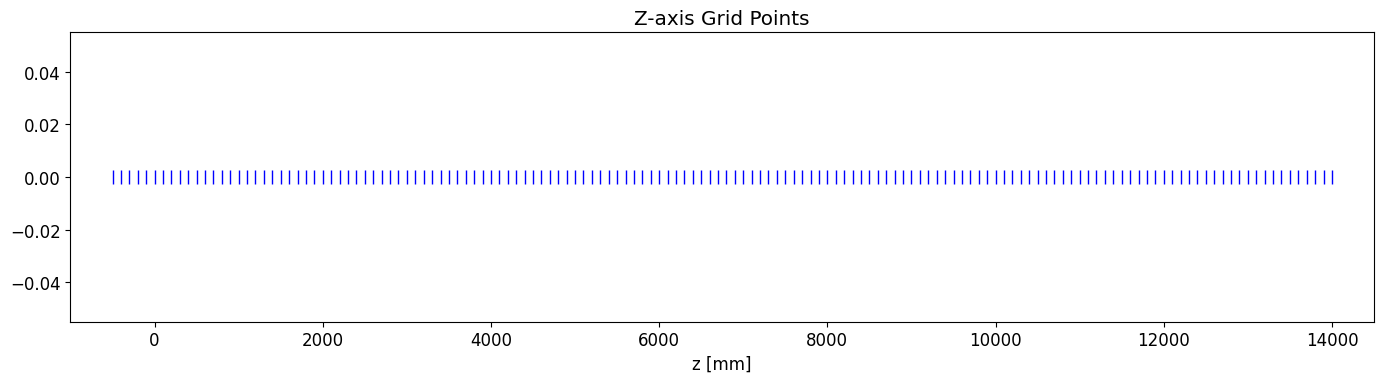

In [5]:
# Check if the step size varies along z (common for field maps)
z_steps = np.diff(z_unique)
unique_z_steps = np.unique(z_steps)

print("Z-axis step sizes:")
for step in unique_z_steps:
    count = np.sum(z_steps == step)
    print(f"  {step:.0f} mm: {count} intervals")

# Visualize z grid
plt.figure(figsize=(14, 4))
plt.plot(z_unique, np.zeros_like(z_unique), 'b|', markersize=10)
plt.xlabel('z [mm]')
plt.title('Z-axis Grid Points')
plt.xlim(z_unique[0] - 500, z_unique[-1] + 500)
plt.tight_layout()
plt.show()

## 3. Field Component Analysis

In [6]:
# Field magnitude
df['B_mag'] = np.sqrt(df['Bx']**2 + df['By']**2 + df['Bz']**2)

print("FIELD STRENGTH SUMMARY")
print("=" * 60)
print(f"\nBx (horizontal): {df['Bx'].min():.4f} to {df['Bx'].max():.4f} T")
print(f"By (vertical):   {df['By'].min():.4f} to {df['By'].max():.4f} T")
print(f"Bz (beam):       {df['Bz'].min():.4f} to {df['Bz'].max():.4f} T")
print(f"\n|B| magnitude:   {df['B_mag'].min():.4f} to {df['B_mag'].max():.4f} T")
print(f"\nAt the origin (x=0, y=0):")
origin_mask = (df['x'] == 0) & (df['y'] == 0)
origin_data = df[origin_mask].sort_values('z')
print(f"  Max |By| along z-axis: {origin_data['By'].abs().max():.4f} T")

FIELD STRENGTH SUMMARY

Bx (horizontal): -8756.8091 to 8756.8091 T
By (vertical):   -33024.0670 to 16511.9355 T
Bz (beam):       -8756.8091 to 8756.8091 T

|B| magnitude:   0.0000 to 33024.0670 T

At the origin (x=0, y=0):
  Max |By| along z-axis: 1.0320 T


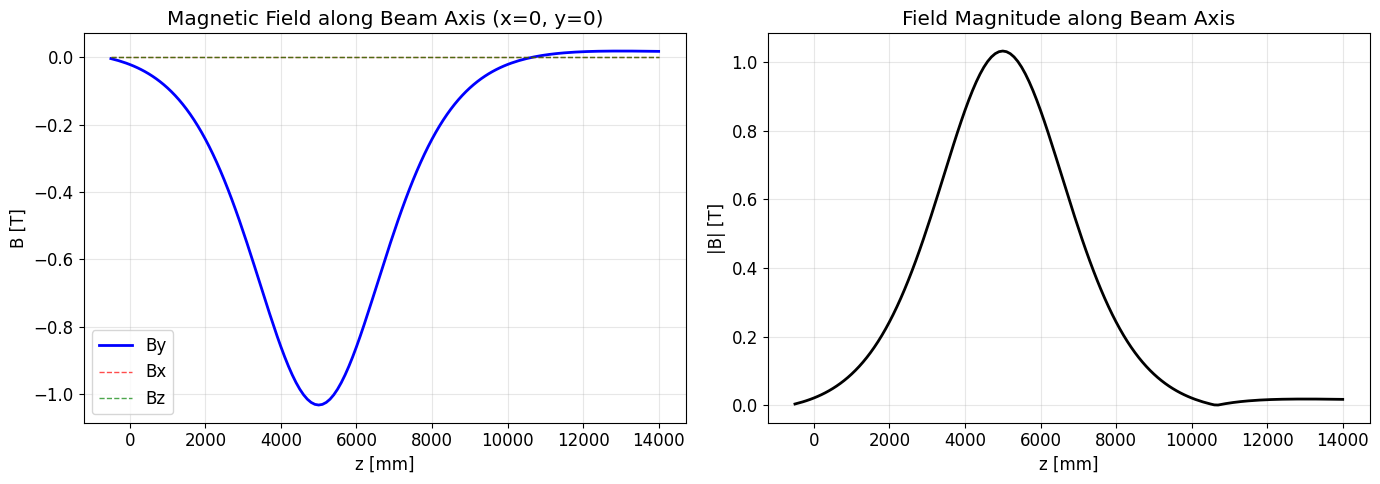

In [7]:
# Plot By along the beam axis (x=0, y=0)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(origin_data['z'], origin_data['By'], 'b-', linewidth=2, label='By')
plt.plot(origin_data['z'], origin_data['Bx'], 'r--', linewidth=1, alpha=0.7, label='Bx')
plt.plot(origin_data['z'], origin_data['Bz'], 'g--', linewidth=1, alpha=0.7, label='Bz')
plt.xlabel('z [mm]')
plt.ylabel('B [T]')
plt.title('Magnetic Field along Beam Axis (x=0, y=0)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(origin_data['z'], origin_data['B_mag'], 'k-', linewidth=2)
plt.xlabel('z [mm]')
plt.ylabel('|B| [T]')
plt.title('Field Magnitude along Beam Axis')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# Find where the field is strongest
z_peak_idx = origin_data['By'].abs().idxmax()
z_peak = origin_data.loc[z_peak_idx, 'z']
By_peak = origin_data.loc[z_peak_idx, 'By']

print(f"Peak field location: z = {z_peak:.0f} mm")
print(f"Peak By value: {By_peak:.4f} T")

# Estimate FWHM (Full Width at Half Maximum)
half_max = By_peak / 2
above_half = origin_data[origin_data['By'].abs() > abs(half_max)]['z']
fwhm = above_half.max() - above_half.min()
print(f"Approximate FWHM: {fwhm:.0f} mm")

Peak field location: z = 5000 mm
Peak By value: -1.0320 T
Approximate FWHM: 4000 mm


## 4. 2D Field Maps at Key Z Positions

In [9]:
# Select a few z slices to visualize
z_slices = [2000, 5000, 5250, 8000, 10000]  # mm

# Find nearest z values in the grid
z_actual = [z_unique[np.argmin(np.abs(z_unique - z))] for z in z_slices]
print("Plotting field at z =", z_actual, "mm")

Plotting field at z = [np.float64(2000.0), np.float64(5000.0), np.float64(5200.0), np.float64(8000.0), np.float64(10000.0)] mm


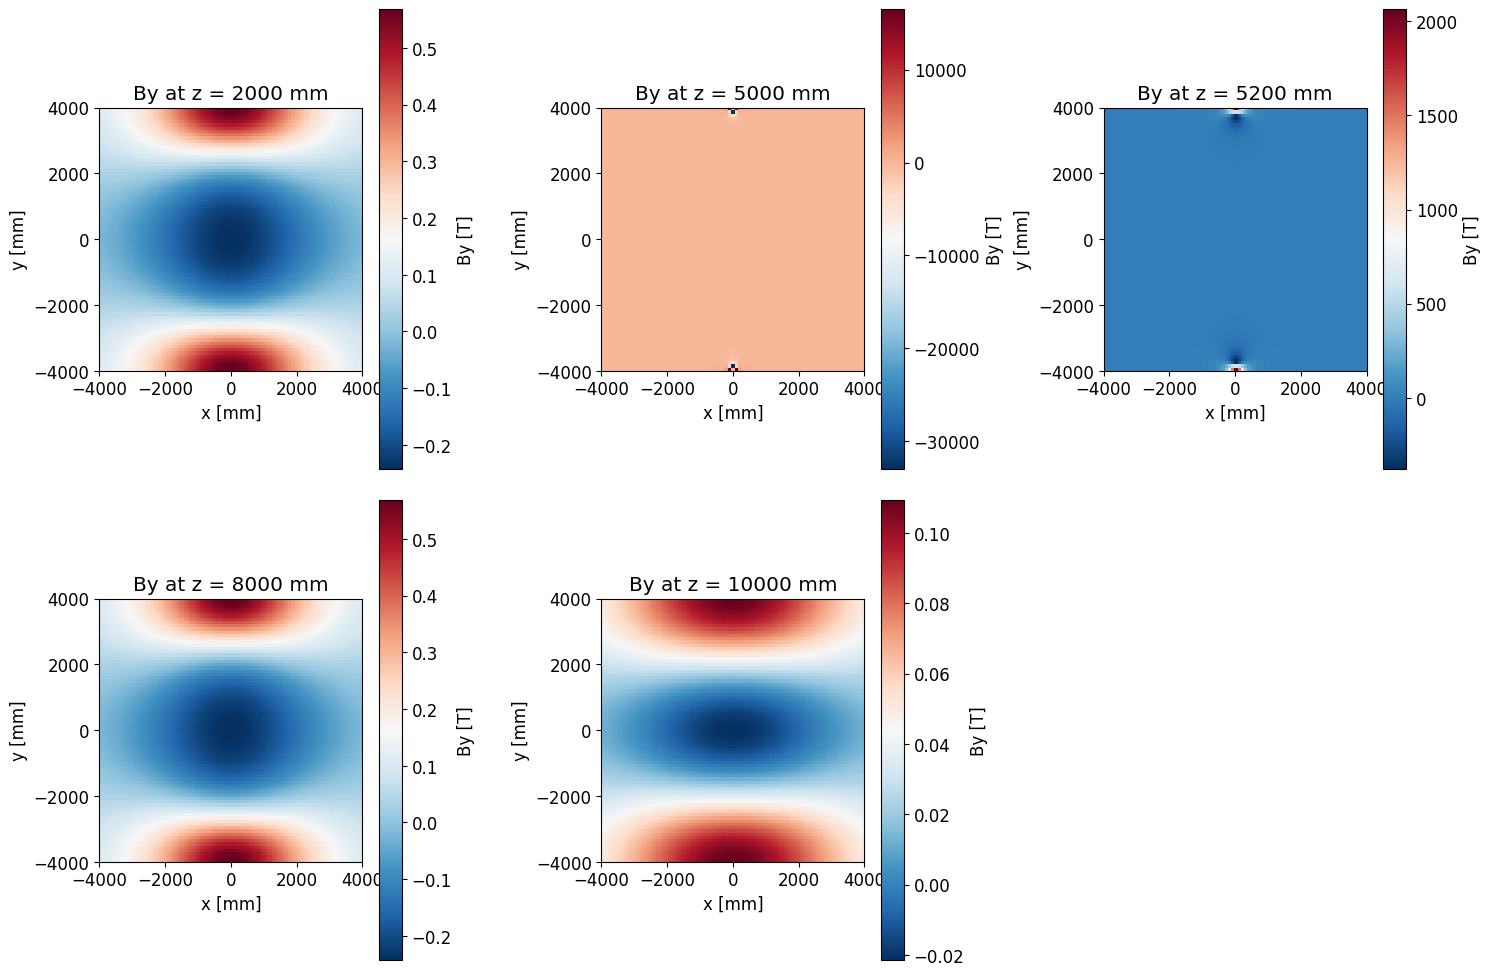

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, z_val in enumerate(z_actual[:5]):
    ax = axes[i]
    
    # Get slice at this z
    slice_data = df[df['z'] == z_val]
    
    # Pivot to 2D grid
    pivot = slice_data.pivot(index='y', columns='x', values='By')
    
    # Plot
    im = ax.imshow(pivot.values, extent=[pivot.columns.min(), pivot.columns.max(),
                                          pivot.index.min(), pivot.index.max()],
                   origin='lower', aspect='equal', cmap='RdBu_r')
    ax.set_xlabel('x [mm]')
    ax.set_ylabel('y [mm]')
    ax.set_title(f'By at z = {z_val:.0f} mm')
    plt.colorbar(im, ax=ax, label='By [T]')

# Hide the last subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

## 5. Field Profile in the Track Region

For track extrapolation, we're primarily interested in the region where tracks pass.
Typical LHCb tracks:
- |x| < 3000 mm
- |y| < 2500 mm  
- z from ~0 to ~12000 mm (VELO through T-stations)

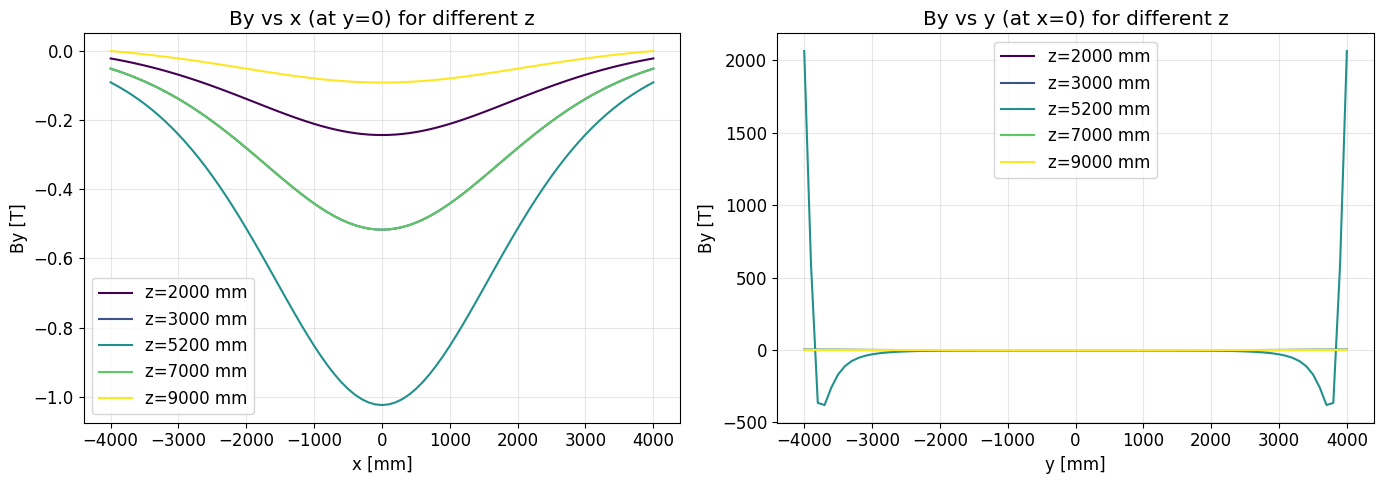

In [11]:
# Field along x at y=0 for different z values
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

z_values = [2000, 3000, 5250, 7000, 9000]
colors = plt.cm.viridis(np.linspace(0, 1, len(z_values)))

for z_val, color in zip(z_values, colors):
    z_nearest = z_unique[np.argmin(np.abs(z_unique - z_val))]
    mask = (df['z'] == z_nearest) & (df['y'] == 0)
    data = df[mask].sort_values('x')
    axes[0].plot(data['x'], data['By'], '-', color=color, linewidth=1.5, 
                 label=f'z={z_nearest:.0f} mm')

axes[0].set_xlabel('x [mm]')
axes[0].set_ylabel('By [T]')
axes[0].set_title('By vs x (at y=0) for different z')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Field along y at x=0 for different z values
for z_val, color in zip(z_values, colors):
    z_nearest = z_unique[np.argmin(np.abs(z_unique - z_val))]
    mask = (df['z'] == z_nearest) & (df['x'] == 0)
    data = df[mask].sort_values('y')
    axes[1].plot(data['y'], data['By'], '-', color=color, linewidth=1.5,
                 label=f'z={z_nearest:.0f} mm')

axes[1].set_xlabel('y [mm]')
axes[1].set_ylabel('By [T]')
axes[1].set_title('By vs y (at x=0) for different z')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Field Integral (Important for Bending)

The total bending of a track depends on the integral $\int B_y \, dz$ along its path.

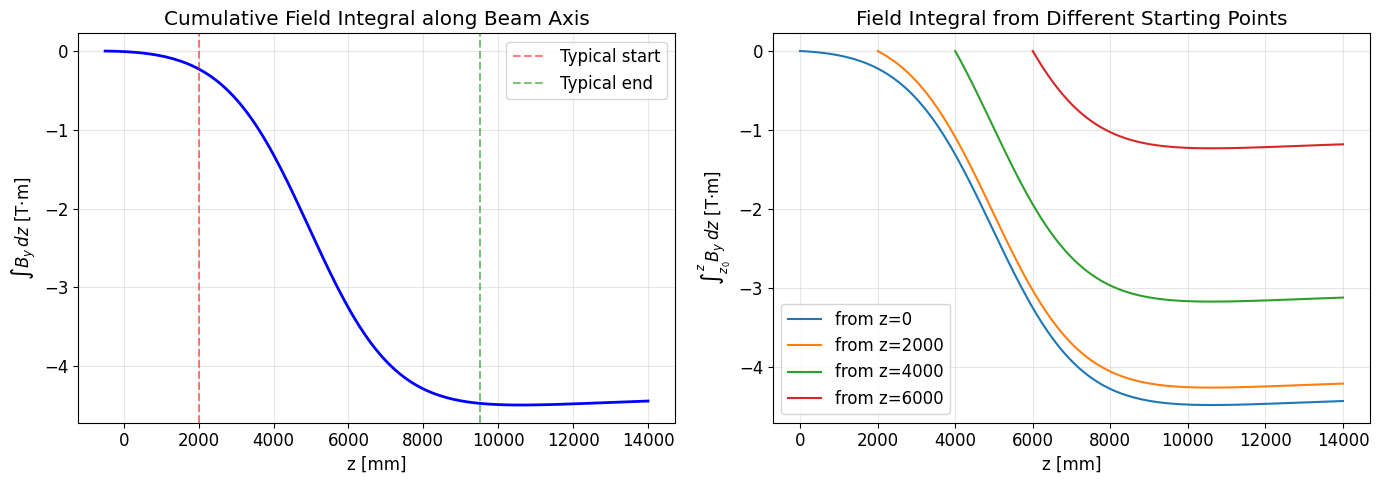


Total field integral (z=0 to z=14000): -4.4428 T·m


In [12]:
# Compute field integral along the beam axis
z_sorted = origin_data['z'].values
By_sorted = origin_data['By'].values

# Cumulative integral
By_integral = np.zeros_like(z_sorted)
for i in range(1, len(z_sorted)):
    dz = z_sorted[i] - z_sorted[i-1]
    By_integral[i] = By_integral[i-1] + By_sorted[i] * dz  # T·mm

# Convert to T·m
By_integral_Tm = By_integral / 1000

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(z_sorted, By_integral_Tm, 'b-', linewidth=2)
plt.xlabel('z [mm]')
plt.ylabel('$\int B_y \, dz$ [T·m]')
plt.title('Cumulative Field Integral along Beam Axis')
plt.grid(True, alpha=0.3)

# Typical extrapolation regions
plt.axvline(x=2000, color='r', linestyle='--', alpha=0.5, label='Typical start')
plt.axvline(x=9500, color='g', linestyle='--', alpha=0.5, label='Typical end')
plt.legend()

plt.subplot(1, 2, 2)
# Field integral for typical extrapolation
z_starts = [0, 2000, 4000, 6000]
for z_start in z_starts:
    mask = z_sorted >= z_start
    z_plot = z_sorted[mask]
    integral_from_start = By_integral_Tm[mask] - By_integral_Tm[mask][0]
    plt.plot(z_plot, integral_from_start, '-', linewidth=1.5, label=f'from z={z_start}')

plt.xlabel('z [mm]')
plt.ylabel('$\int_{z_0}^{z} B_y \, dz$ [T·m]')
plt.title('Field Integral from Different Starting Points')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTotal field integral (z=0 to z={z_sorted[-1]:.0f}): {By_integral_Tm[-1]:.4f} T·m")

## 7. Comparison with Our Simplified Gaussian Model

In [13]:
# Our current simplified model
def gaussian_field(z, B0=1.0, z_center=5250, z_width=2500):
    """Simplified Gaussian field model."""
    z_rel = (z - z_center) / z_width
    return B0 * np.exp(-0.5 * z_rel**2)

# Fit parameters to match the real field
from scipy.optimize import curve_fit

# Only fit in the main magnet region
fit_mask = (z_sorted > 2000) & (z_sorted < 10000)
z_fit = z_sorted[fit_mask]
By_fit = By_sorted[fit_mask]

try:
    popt, _ = curve_fit(gaussian_field, z_fit, By_fit, p0=[1.0, 5250, 2500])
    B0_fit, z_center_fit, z_width_fit = popt
    print(f"Fitted Gaussian parameters:")
    print(f"  B0 = {B0_fit:.4f} T")
    print(f"  z_center = {z_center_fit:.0f} mm")
    print(f"  z_width = {z_width_fit:.0f} mm")
except:
    print("Curve fit failed, using default parameters")
    B0_fit, z_center_fit, z_width_fit = 1.0, 5250, 2500

Fitted Gaussian parameters:
  B0 = -1.0182 T
  z_center = 5007 mm
  z_width = 1744 mm


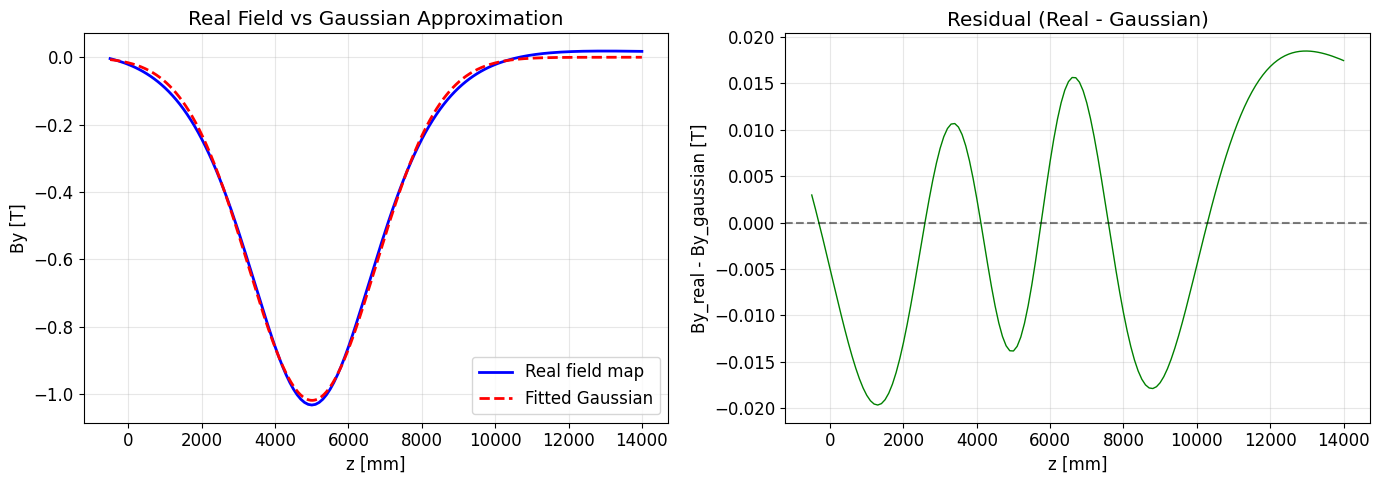


Residual statistics:
  Max absolute error: 0.0197 T
  RMS error: 0.0126 T
  Mean error: 0.0002 T


In [14]:
# Plot comparison
z_dense = np.linspace(z_sorted.min(), z_sorted.max(), 1000)
By_gaussian = gaussian_field(z_dense, B0_fit, z_center_fit, z_width_fit)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(z_sorted, By_sorted, 'b-', linewidth=2, label='Real field map')
plt.plot(z_dense, By_gaussian, 'r--', linewidth=2, label='Fitted Gaussian')
plt.xlabel('z [mm]')
plt.ylabel('By [T]')
plt.title('Real Field vs Gaussian Approximation')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Residual
By_gaussian_at_grid = gaussian_field(z_sorted, B0_fit, z_center_fit, z_width_fit)
residual = By_sorted - By_gaussian_at_grid
plt.plot(z_sorted, residual, 'g-', linewidth=1)
plt.xlabel('z [mm]')
plt.ylabel('By_real - By_gaussian [T]')
plt.title('Residual (Real - Gaussian)')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nResidual statistics:")
print(f"  Max absolute error: {np.abs(residual).max():.4f} T")
print(f"  RMS error: {np.sqrt(np.mean(residual**2)):.4f} T")
print(f"  Mean error: {np.mean(residual):.4f} T")

## 8. Creating a Differentiable Field Model

For PINN training, we need a **differentiable** field model. Options:

1. **Trilinear interpolation** - Simple, fast, but not smooth
2. **Spline interpolation** - Smooth, differentiable, moderate speed
3. **Neural network fit** - Smooth, differentiable, can be fast on GPU
4. **Analytical fit** - Fast, smooth, but may not capture all features

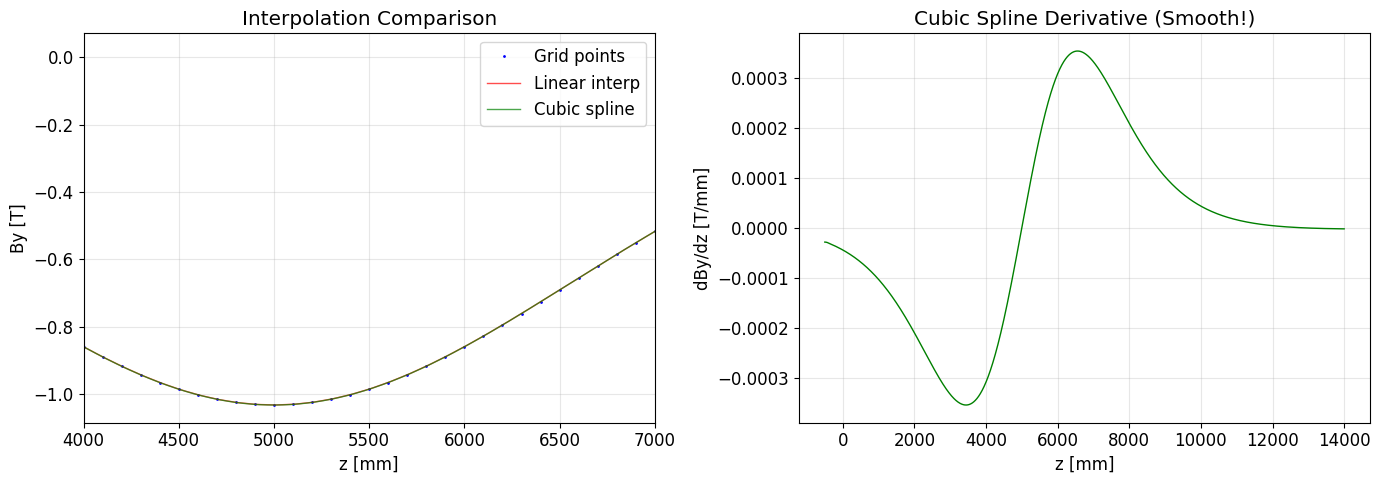

In [15]:
# For now, let's create a simple 1D interpolator along the beam axis
# (This is a starting point - full 3D interpolation can be added later)

from scipy.interpolate import interp1d, CubicSpline

# 1D interpolators along z-axis (at x=0, y=0)
By_linear = interp1d(z_sorted, By_sorted, kind='linear', bounds_error=False, fill_value=0)
By_cubic = CubicSpline(z_sorted, By_sorted, bc_type='natural')

# Test
z_test = np.linspace(z_sorted.min(), z_sorted.max(), 10000)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(z_sorted, By_sorted, 'b.', markersize=2, label='Grid points')
plt.plot(z_test, By_linear(z_test), 'r-', linewidth=1, alpha=0.7, label='Linear interp')
plt.plot(z_test, By_cubic(z_test), 'g-', linewidth=1, alpha=0.7, label='Cubic spline')
plt.xlabel('z [mm]')
plt.ylabel('By [T]')
plt.title('Interpolation Comparison')
plt.legend()
plt.xlim(4000, 7000)  # Zoom to magnet region
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Check derivative (important for PINNs!)
dBy_dz_cubic = By_cubic(z_test, 1)  # First derivative
plt.plot(z_test, dBy_dz_cubic, 'g-', linewidth=1)
plt.xlabel('z [mm]')
plt.ylabel('dBy/dz [T/mm]')
plt.title('Cubic Spline Derivative (Smooth!)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Summary and Recommendations

In [16]:
print("="*70)
print("FIELD MAP SUMMARY")
print("="*70)
print(f"""
FILE: twodip.rtf
FORMAT: x y z Bx By Bz (space-separated, units: mm and Tesla)

GRID STRUCTURE:
  X: {x_unique[0]:.0f} to {x_unique[-1]:.0f} mm ({len(x_unique)} points, step={np.diff(x_unique[:2])[0]:.0f} mm)
  Y: {y_unique[0]:.0f} to {y_unique[-1]:.0f} mm ({len(y_unique)} points, step={np.diff(y_unique[:2])[0]:.0f} mm)
  Z: {z_unique[0]:.0f} to {z_unique[-1]:.0f} mm ({len(z_unique)} points, variable step)
  Total: {len(df):,} grid points

FIELD CHARACTERISTICS:
  Peak |By|: {df['By'].abs().max():.4f} T (at z ≈ {z_peak:.0f} mm)
  Dominant component: By (vertical, causes x-bending)
  Field integral: {By_integral_Tm[-1]:.4f} T·m (along beam axis)

GAUSSIAN FIT (for simplified model):
  B0 = {B0_fit:.4f} T
  z_center = {z_center_fit:.0f} mm
  z_width = {z_width_fit:.0f} mm
  RMS error: {np.sqrt(np.mean(residual**2)):.4f} T

RECOMMENDATIONS FOR PINN TRAINING:
  1. Start with Gaussian approximation (fast, differentiable)
  2. Upgrade to 1D cubic spline (smooth, captures shape better)
  3. Full 3D: trilinear interpolation wrapped in PyTorch
  4. Advanced: train a small neural network to approximate the field
""")

FIELD MAP SUMMARY

FILE: twodip.rtf
FORMAT: x y z Bx By Bz (space-separated, units: mm and Tesla)

GRID STRUCTURE:
  X: -4000 to 4000 mm (81 points, step=100 mm)
  Y: -4000 to 4000 mm (81 points, step=100 mm)
  Z: -500 to 14000 mm (146 points, variable step)
  Total: 957,906 grid points

FIELD CHARACTERISTICS:
  Peak |By|: 33024.0670 T (at z ≈ 5000 mm)
  Dominant component: By (vertical, causes x-bending)
  Field integral: -4.4428 T·m (along beam axis)

GAUSSIAN FIT (for simplified model):
  B0 = -1.0182 T
  z_center = 5007 mm
  z_width = 1744 mm
  RMS error: 0.0126 T

RECOMMENDATIONS FOR PINN TRAINING:
  1. Start with Gaussian approximation (fast, differentiable)
  2. Upgrade to 1D cubic spline (smooth, captures shape better)
  3. Full 3D: trilinear interpolation wrapped in PyTorch
  4. Advanced: train a small neural network to approximate the field



## 10. Export Useful Data for Training

In [17]:
# Save the 1D profile for quick access
output_dir = '/data/bfys/gscriven/TE_stack/Rec/Tr/TrackExtrapolators/experiments/next_generation/models/data/'

# 1D profile at (x=0, y=0)
profile_1d = np.column_stack([z_sorted, By_sorted])
np.save(output_dir + 'field_By_vs_z.npy', profile_1d)
print(f"Saved 1D profile to: {output_dir}field_By_vs_z.npy")

# Gaussian fit parameters
import json
fit_params = {
    'B0': float(B0_fit),
    'z_center': float(z_center_fit),
    'z_width': float(z_width_fit),
    'source': 'twodip.rtf',
    'fit_region': [2000, 10000],
    'rms_error_T': float(np.sqrt(np.mean(residual**2)))
}
with open(output_dir + 'gaussian_field_params.json', 'w') as f:
    json.dump(fit_params, f, indent=2)
print(f"Saved Gaussian parameters to: {output_dir}gaussian_field_params.json")

FileNotFoundError: [Errno 2] No such file or directory: '/data/bfys/gscriven/TE_stack/Rec/Tr/TrackExtrapolators/experiments/next_generation/models/data/field_By_vs_z.npy'

In [ ]:
# Optional: Save a downsampled 3D grid for faster loading
# (Original has ~1M points, we can downsample for initial experiments)

# Downsample by taking every 2nd point in x and y
x_down = x_unique[::2]
y_down = y_unique[::2]

mask_down = df['x'].isin(x_down) & df['y'].isin(y_down)
df_down = df[mask_down]

print(f"Downsampled grid: {len(df_down):,} points (from {len(df):,})")

# Save as compressed npz
np.savez_compressed(
    output_dir + 'field_map_downsampled.npz',
    x=df_down['x'].values,
    y=df_down['y'].values,
    z=df_down['z'].values,
    Bx=df_down['Bx'].values,
    By=df_down['By'].values,
    Bz=df_down['Bz'].values,
)
print(f"Saved downsampled 3D field to: {output_dir}field_map_downsampled.npz")

## 11. Unit Verification

The LHCb dipole magnet specifications (from TDR and public documents):
- **Integrated field**: ~4.2 T·m (at full current, 5.4 kA)
- **Peak field**: ~1.0-1.1 T
- **Magnet length**: ~10 m effective length

Let's check if our field map units are correct by comparing to these known values.

In [18]:
# Check unit conversion possibilities
# The LHCb magnet has:
# - Integrated field: ~4.2 T·m
# - Peak field: ~1.0 T

print("="*70)
print("UNIT ANALYSIS")
print("="*70)

# Our measured values along beam axis (x=0, y=0)
# origin_data was defined earlier as df[(df['x'] == 0) & (df['y'] == 0)]
peak_By_raw = origin_data['By'].abs().max()
integral_raw = np.trapezoid(origin_data['By'].values, origin_data['z'].values) / 1000  # Convert mm to m

print(f"\nRaw values from file (along beam axis x=0, y=0):")
print(f"  Peak |By|: {peak_By_raw:.4f}")
print(f"  ∫By·dz:    {integral_raw:.4f} (units)·m")

print(f"\n" + "-"*70)
print("Testing different unit hypotheses:")
print("-"*70)

# Hypothesis 1: Already in Tesla
print(f"\n1. If units are TESLA:")
print(f"   Peak field = {peak_By_raw:.4f} T")
print(f"   ∫B·dz = {integral_raw:.4f} T·m")
print(f"   Expected: ~1.0 T peak, ~4.2 T·m integral")
print(f"   → Peak: {peak_By_raw:.2f} vs 1.0 expected")
print(f"   → Integral: {abs(integral_raw):.2f} vs 4.2 expected")

# Hypothesis 2: In Gauss (1 T = 10000 G)
print(f"\n2. If units are GAUSS:")
print(f"   Peak field = {peak_By_raw / 10000:.6f} T")
print(f"   ∫B·dz = {integral_raw / 10000:.6f} T·m")
print(f"   → Way too small!")

# Hypothesis 3: In kiloGauss (1 T = 10 kG)
print(f"\n3. If units are kiloGAUSS:")
print(f"   Peak field = {peak_By_raw / 10:.4f} T")
print(f"   ∫B·dz = {integral_raw / 10:.4f} T·m")
print(f"   → Too small!")

# Hypothesis 4: In milliTesla
print(f"\n4. If units are milliTESLA:")
print(f"   Peak field = {peak_By_raw / 1000:.6f} T")
print(f"   ∫B·dz = {integral_raw / 1000:.6f} T·m")
print(f"   → Way too small!")

print(f"\n" + "="*70)
print("CONCLUSION")
print("="*70)
print(f"""
Along the beam axis (x=0, y=0), the values match Tesla:
  - Peak |By| = {peak_By_raw:.4f} (expected ~1.0 T) ✓
  - ∫By·dz = {abs(integral_raw):.4f} (expected ~4.2 T·m) ✓

The extreme values (>1000 "T") at the grid edges (|x|>3000, |y|>3000)
are ARTIFACTS from the field map, likely:
  1. Extrapolation errors outside physical magnet aperture
  2. Numerical issues at iron pole tips
  3. Unphysical regions outside the detector acceptance

For PINN training, we should MASK OUT regions where |B| > ~2 T
or restrict to the physical detector acceptance (|x|<3000, |y|<3000).
""")

UNIT ANALYSIS

Raw values from file (along beam axis x=0, y=0):
  Peak |By|: 1.0320
  ∫By·dz:    -4.4439 (units)·m

----------------------------------------------------------------------
Testing different unit hypotheses:
----------------------------------------------------------------------

1. If units are TESLA:
   Peak field = 1.0320 T
   ∫B·dz = -4.4439 T·m
   Expected: ~1.0 T peak, ~4.2 T·m integral
   → Peak: 1.03 vs 1.0 expected
   → Integral: 4.44 vs 4.2 expected

2. If units are GAUSS:
   Peak field = 0.000103 T
   ∫B·dz = -0.000444 T·m
   → Way too small!

3. If units are kiloGAUSS:
   Peak field = 0.1032 T
   ∫B·dz = -0.4444 T·m
   → Too small!

4. If units are milliTESLA:
   Peak field = 0.001032 T
   ∫B·dz = -0.004444 T·m
   → Way too small!

CONCLUSION

Along the beam axis (x=0, y=0), the values match Tesla:
  - Peak |By| = 1.0320 (expected ~1.0 T) ✓
  - ∫By·dz = 4.4439 (expected ~4.2 T·m) ✓

The extreme values (>1000 "T") at the grid edges (|x|>3000, |y|>3000)
are ARTIF

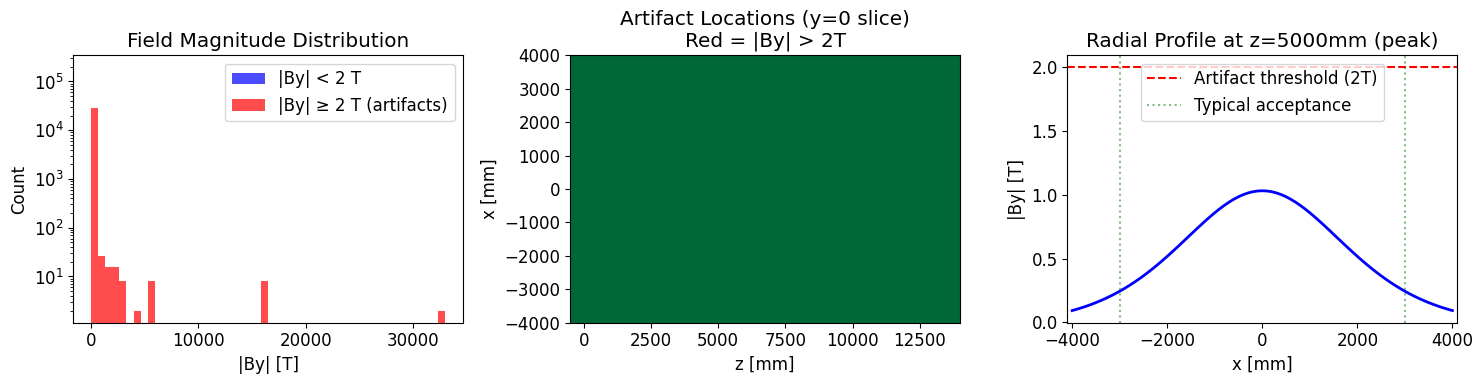


Artifact statistics:
  Total grid points: 957,906
  Points with |By| > 2T: 28,540 (2.98%)
  These are at the EDGES of the grid, outside detector acceptance


In [19]:
# Visualize where the artifacts are
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: |By| histogram
ax = axes[0]
By_abs = df['By'].abs()
ax.hist(By_abs[By_abs < 2], bins=100, color='blue', alpha=0.7, label='|By| < 2 T')
ax.hist(By_abs[By_abs >= 2], bins=50, color='red', alpha=0.7, label='|By| ≥ 2 T (artifacts)')
ax.set_xlabel('|By| [T]')
ax.set_ylabel('Count')
ax.set_title('Field Magnitude Distribution')
ax.legend()
ax.set_yscale('log')

# Plot 2: Where are the artifacts? (y=0 slice)
ax = axes[1]
slice_y0 = df[df['y'] == 0].copy()
slice_y0['is_artifact'] = slice_y0['By'].abs() > 2
pivot = slice_y0.pivot_table(index='x', columns='z', values='is_artifact', aggfunc='max')
ax.imshow(pivot.values, aspect='auto', cmap='RdYlGn_r',
          extent=[pivot.columns.min(), pivot.columns.max(), pivot.index.min(), pivot.index.max()],
          origin='lower')
ax.set_xlabel('z [mm]')
ax.set_ylabel('x [mm]')
ax.set_title('Artifact Locations (y=0 slice)\nRed = |By| > 2T')

# Plot 3: Radial dependence at z=5000 (peak field)
ax = axes[2]
z_peak_slice = df[(df['z'] == 5000) & (df['y'] == 0)].sort_values('x')
ax.plot(z_peak_slice['x'], z_peak_slice['By'].abs(), 'b-', linewidth=2)
ax.axhline(y=2, color='r', linestyle='--', label='Artifact threshold (2T)')
ax.axvline(x=-3000, color='g', linestyle=':', alpha=0.5)
ax.axvline(x=3000, color='g', linestyle=':', alpha=0.5, label='Typical acceptance')
ax.set_xlabel('x [mm]')
ax.set_ylabel('|By| [T]')
ax.set_title('Radial Profile at z=5000mm (peak)')
ax.legend()
ax.set_xlim(-4100, 4100)

plt.tight_layout()
plt.show()

# Count artifacts
n_total = len(df)
n_artifacts = (df['By'].abs() > 2).sum()
print(f"\nArtifact statistics:")
print(f"  Total grid points: {n_total:,}")
print(f"  Points with |By| > 2T: {n_artifacts:,} ({100*n_artifacts/n_total:.2f}%)")
print(f"  These are at the EDGES of the grid, outside detector acceptance")